# Exploration notebook

## Summary

- This dataset contains anonymized features pertaining to a time-varying value for a financial instrument.
- Each instrument has an id. Time is represented by the 'timestamp' feature and the variable to predict is 'y'.
- No further information will be provided on the meaning of the features, the transformations that were applied to them, the timescale, or the type of instruments that are included in the data.


In addition to the data, you will need to familiarize yourself with the Kernels environment and the competition data API. The API is designed to prevent accessing data beyond the timestamp for which you are predicting and informs you which ids require predictions at which timestamps. The API also provides a "reward" for each timestamp, in the form of an average R value over the predicted values for the previous day. You may choose to use this reward to do reinforcement-style learning. Your code should expect and handle missing values.

We have setup the kernels environment such that the code structure you use for training on the test set (clicking "Run") will ideally work for submissions on the test set (clicking "Submit"). To achieve this, we have partitioned the training set such that the first half is provided as a training set at the start of a run, and the latter half is streamed through the API, as though it is a holdout set. In other words:

Run: first half of training set (split by time) provided initially, second half of training set used for API/predictions.
Submit: all of training set provided initially, test set used for API/predictions.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#pd.read_csv(r"..\input\test.csv")

df = pd.read_hdf(r"..\input\train.h5")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df.head(5)

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


In [4]:
df.describe()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
count,1.710756e+06,1.710756e+06,1.637797e+06,1.629727e+06,1.312105e+06,1.561285e+06,1.304298e+06,1.686809e+06,1.031686e+06,1.341916e+06,...,1.708204e+06,1.691591e+06,1.691591e+06,1.690740e+06,1.708520e+06,1.666567e+06,1.690755e+06,1.706070e+06,1.473977e+06,1.710756e+06
mean,1.093858e+03,9.456257e+02,-4.536046e+00,7.729436e+11,-3.320328e-01,-5.046012e-01,1.801661e+01,-2.040938e-02,-5.703754e+08,-1.622954e-01,...,-8.584833e-02,-9.103397e-02,-8.156685e-02,-7.287001e-02,4.908321e-02,5.236218e-03,-1.699966e-02,-9.735299e-01,3.881475e-04,2.217509e-04
std,6.308563e+02,5.195685e+02,2.497382e+02,7.620606e+13,6.519810e+01,1.020749e+02,9.258360e+02,2.494859e-01,7.502322e+10,3.668149e+00,...,6.125852e-01,2.471038e-01,2.346534e-01,2.235729e-01,3.102316e-01,1.133733e-01,2.116284e-01,9.605551e-01,3.011983e-02,2.240643e-02
min,0.000000e+00,0.000000e+00,-2.017497e+04,-7.375435e-02,-9.848880e+03,-3.434176e+04,-8.551914e+03,-2.344957e+00,-1.043737e+13,-1.077101e+03,...,-1.687572e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.250904e-01,-4.449529e-01,-1.000000e+00,-2.000000e+00,-1.265686e-01,-8.609413e-02
25%,5.500000e+02,5.040000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.561389e-03
50%,1.098000e+03,9.560000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.570681e-04
75%,1.657000e+03,1.401000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.520990e-03
max,2.158000e+03,1.812000e+03,3.252527e+03,1.068448e+16,3.823001e+03,1.239737e+03,6.785965e+04,1.378195e+00,5.203165e+02,7.677125e+01,...,4.957758e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.569265e+00,6.844833e-01,1.000000e+00,0.000000e+00,1.435858e-01,9.349781e-02


## How many times appears each id?

ids most popular appear in just 1813 rows

In [5]:
import collections
collections.Counter(df['id']).most_common()[:10]

[(11, 1813),
 (12, 1813),
 (25, 1813),
 (26, 1813),
 (31, 1813),
 (38, 1813),
 (39, 1813),
 (40, 1813),
 (41, 1813),
 (43, 1813)]

In [6]:
df.columns

Index([u'id', u'timestamp', u'derived_0', u'derived_1', u'derived_2',
       u'derived_3', u'derived_4', u'fundamental_0', u'fundamental_1',
       u'fundamental_2',
       ...
       u'technical_36', u'technical_37', u'technical_38', u'technical_39',
       u'technical_40', u'technical_41', u'technical_42', u'technical_43',
       u'technical_44', u'y'],
      dtype='object', length=111)

In [24]:
df['y'].describe()

count    1.710756e+06
mean     2.217509e-04
std      2.240643e-02
min     -8.609413e-02
25%     -9.561389e-03
50%     -1.570681e-04
75%      9.520990e-03
max      9.349781e-02
Name: y, dtype: float64

## y label variable

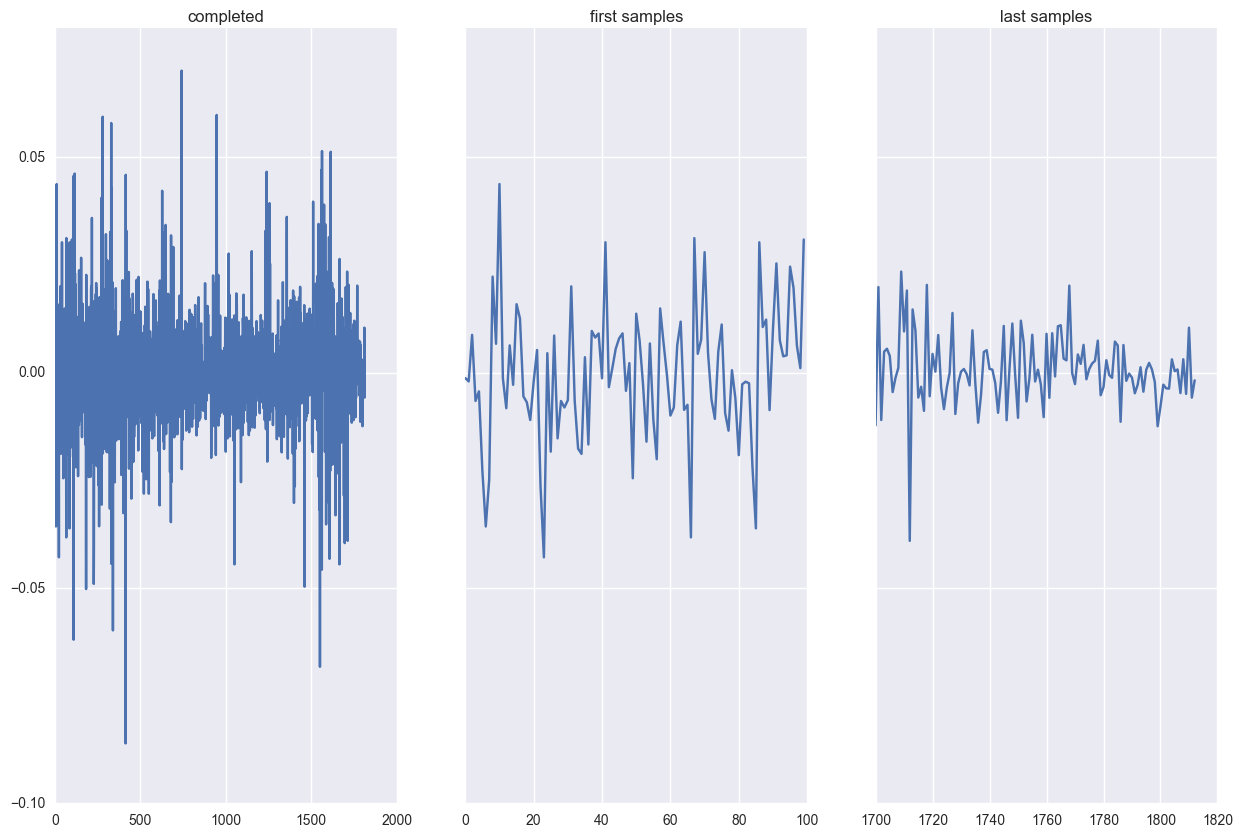

In [39]:
t = df[df['id']==11]['timestamp']
y = df[df['id']==11]['y']

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
ax1.plot(t, y); ax1.set_title('completed')
ax2.plot(t[:100], y[:100]); ax2.set_title('first samples')
ax3.plot(t[1700:], y[1700:]); ax3.set_title('last samples')
plt.show()

# derived_ variables

### derived_2 is higher than other derived_params

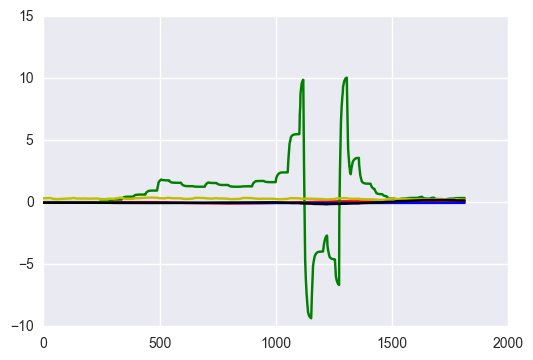

In [11]:
t = df[df['id']==11]['timestamp']
x_derived_0 = df[df['id']==11]['derived_0']
x_derived_1 = df[df['id']==11]['derived_1']
x_derived_2 = df[df['id']==11]['derived_2']
x_derived_3 = df[df['id']==11]['derived_3']
x_derived_4 = df[df['id']==11]['derived_4']
plt.plot(t, x_derived_0,'r', t, x_derived_1, 'b', t, x_derived_2, 'g', t, x_derived_3, 'y', t, x_derived_4, 'k')
plt.show()

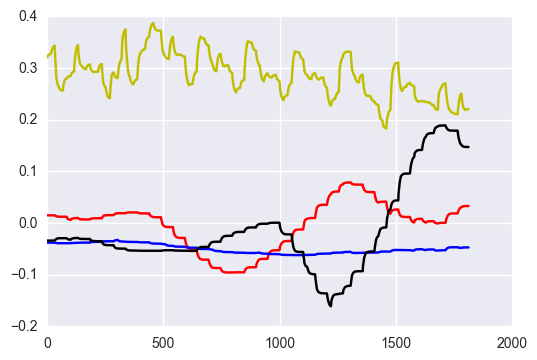

In [12]:
t = df[df['id']==11]['timestamp']
x_derived_0 = df[df['id']==11]['derived_0']
x_derived_1 = df[df['id']==11]['derived_1']
x_derived_3 = df[df['id']==11]['derived_3']
x_derived_4 = df[df['id']==11]['derived_4']
plt.plot(t, x_derived_0,'r', t, x_derived_1, 'b', t, x_derived_3, 'y', t, x_derived_4, 'k')
plt.show()

# fundamental_ variables

comments:

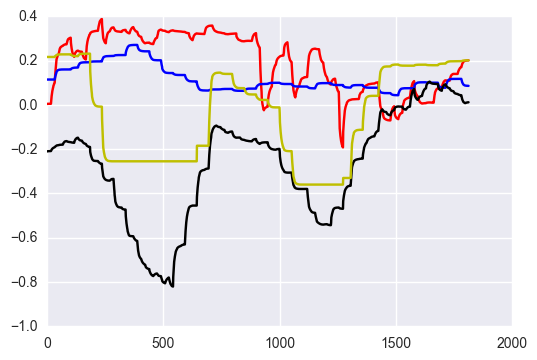

In [8]:
t = df[df['id']==11]['timestamp']
x_fund_0 = df[df['id']==11]['fundamental_0']
x_fund_1 = df[df['id']==11]['fundamental_1']
x_fund_2 = df[df['id']==11]['fundamental_2']
x_fund_3 = df[df['id']==11]['fundamental_3']
#x_fund_4 = df[df['id']==11]['fundamental_4']
plt.plot(t, x_fund_0,'r', t, x_fund_1, 'b', t, x_fund_2, 'k', t, x_fund_3, 'y')
plt.show()

## technical_ variables

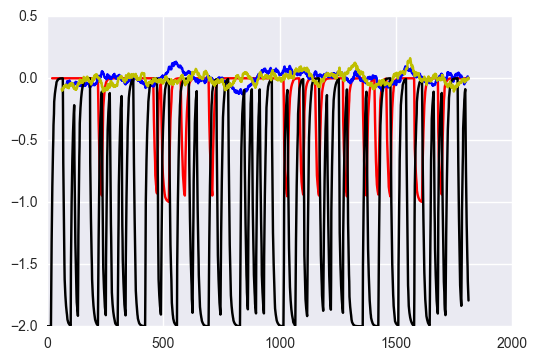

In [14]:
t = df[df['id']==11]['timestamp']
x_tech_0 = df[df['id']==11]['technical_0']
x_tech_1 = df[df['id']==11]['technical_1']
x_tech_2 = df[df['id']==11]['technical_2']
x_tech_3 = df[df['id']==11]['technical_3']
#x_fund_4 = df[df['id']==11]['fundamental_4']
plt.plot(t, x_tech_0,'r', t, x_tech_1, 'b', t, x_tech_2, 'k', t, x_tech_3, 'y')
plt.show()

### same for id 25, same variability

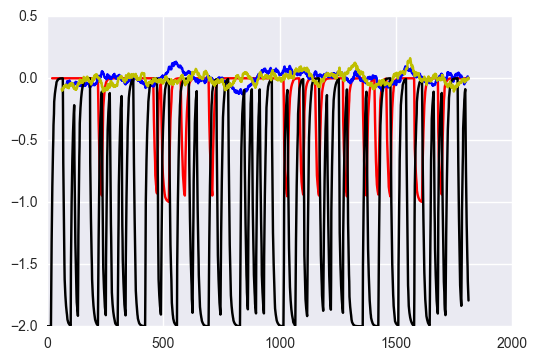

In [21]:
t = df[df['id']==25]['timestamp']
x_tech_0 = df[df['id']==11]['technical_0']
x_tech_1 = df[df['id']==11]['technical_1']
x_tech_2 = df[df['id']==11]['technical_2']
x_tech_3 = df[df['id']==11]['technical_3']
#x_fund_4 = df[df['id']==11]['fundamental_4']
plt.plot(t, x_tech_0,'r', t, x_tech_1, 'b', t, x_tech_2, 'k', t, x_tech_3, 'y')
plt.show()

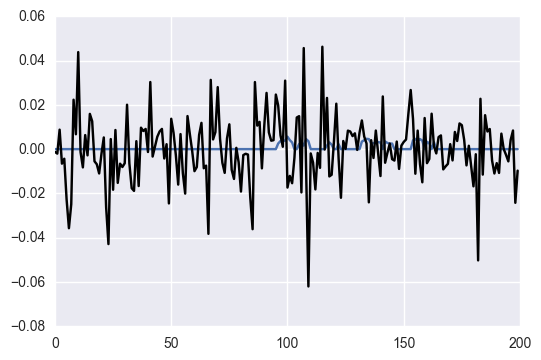

In [44]:
t = df[df['id']==11]['timestamp']
x_tech_20 = df[df['id']==11]['technical_20']

#x_fund_4 = df[df['id']==11]['fundamental_4']
plt.plot(t[:200], x_tech_20[:200], t[:200], y[:200], 'k')
plt.show()